<h1> localization embedding analysis </h1>
<h2> experiment framework </h1>
<ol>
    <li>Select an image, where the yolo predicts an object that is clearly visible with high confidence</li>
    <li>segment the obj and store the segmentation mask</li><br><br>
    <ol>
        <li> <h3>Scale analysis</h3>
            <ul>
                <li>paste scaled up and scaled down versions of the same object, in the same location, such that the center of the bounding box is not changed, as different images with black backgrounds. Compare the difference (which parts if any distinct parts differ) in the embeddings.<br> <br>The difference in embeddings of translations of identical objects of the same scale (ideally different scales also) should correspond directly to the location information change in the embedding. Studying / trying to isolate this change will shed light on the location-specific information/region/component of the embedding.<br><br> The semantic information encoded should be exactly the same for  embeddings of translations because, the the same filter application procedure is applied for all windows of the image.</li> <br>
                <li> find high confidence object with almost identical bounding boxes, place them in the same spatial location in differnet images with black background, and find which parts of the embedding remain similar, these parts correspond to the location information. (you may need to find the similarity among many such examples.)</li>
            </ul>
        </li><br>
        <li> <h3>location Analysis</h3> 
            <ul>
                <li> Take the original mask, and translate it to different parts of the same image with a black background. The final image should have the same object in identical scale, simply translating these duplicates far away parts of the image.</li>
                </li>
                <li>apply yolo on this image, and compare the embeddings of each instance and check what changes, the change should directly correspond to location information. (This probaly has to be done for many images corresponding to different objects ,to get a better idea, of where in the embedding, and how location information is encoded.)</li>
            </ul>
        </li>





## Importing the libraries and including utils

In [1]:
import torch
import os
import cv2
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import cv2


import sys

def include_utils():
    parent_directory = os.path.abspath('/app/utils')
    sys.path.append(parent_directory)

include_utils()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)


from utils.data_utils import load_object_from_file



cuda


## Loading embedding Details

In [2]:
results_path = "/app/bin/results/"

embedding_details = load_object_from_file(os.path.join(results_path, "embedding_details_bf0a8f0be08854a59dccf7b0ba0bb93f_gdsr.pkl"))

## Choosing an Object of interest.

### The object chosen below will be repeatedly used by translating it to different locations and generating embeddings for location-specific information analysis

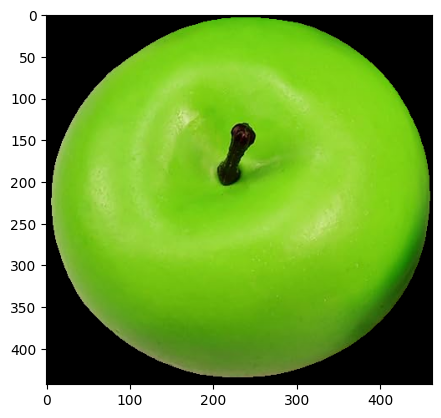

In [3]:
ooi_ind = 5#object of interest index
for i in range(len(embedding_details['class_names'])):

    class_name = embedding_details['class_names'][i]
    mask = embedding_details['masks'][i]
    img = cv2.imread(embedding_details['source_paths'][i].replace('embedding_tester', 'apple_aero_dog'))
    box = embedding_details['bounding_boxes'][i]

    if i!=5:
        continue
    
    # print(f"image shape : {img.shape}, mask shape : {mask.shape}")
    masked_image = img.copy() * np.concatenate([mask[..., None],
                mask[..., None],
                mask[..., None]], axis = 3)[0]
    
    ymin, xmin, ymax, xmax = box[0].astype(int)
    cropped_image = masked_image[xmin:xmax, ymin:ymax, :]
    plt.imshow(cropped_image[:, :, ::-1])
    plt.show()

               

## Making a dataset of images where the same object is tranlated to different locations, and many such images, with differently displaced instaces is made. 

## Random scaled versions

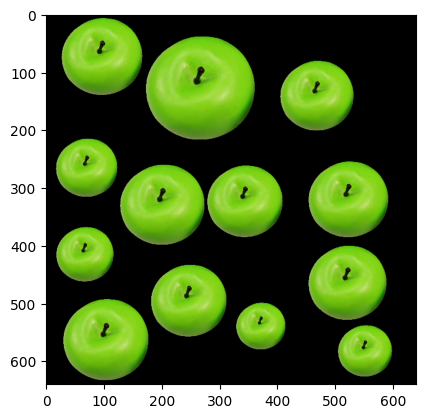

In [5]:
import cv2
import numpy as np
import random

from utils.augment_utils import random_scale
from utils.augment_utils import check_overlap
from utils.augment_utils import place_images

exp_img = np.zeros([1920, 1920, 3])
scale_range = (0.5, 1.5)
result_image = place_images(cropped_image.copy(), exp_img.copy(), scale_range)

im_size = 640
viz_img = cv2.resize(result_image.copy(), (im_size,im_size))
plt.imshow(viz_img[:, :, ::-1].astype(int))
plt.show()   

In [6]:
save_dir_random_scale = "/app/data/images/random_scaled_apples"

for i in range(80):
    exp_img = np.zeros([1920, 1920, 3])
    scale_range = (0.5, 1.5)
    result_image = place_images(cropped_image.copy(), exp_img.copy(), scale_range)
    result_image = cv2.resize(result_image.copy(), (800,800))
    cv2.imwrite(f"{save_dir_random_scale}/apples_indis{i}.jpg", result_image)

## same scale translations

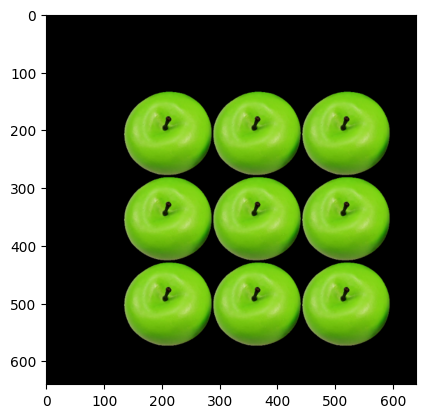

In [9]:


from utils.augment_utils import scale_image
from utils.augment_utils import check_overlap
from utils.augment_utils import place_fixed_scale_images_with_shift


exp_img = np.zeros([1920, 1920, 3])
scale_range = (0.5, 1.5)


obj_dimy, obj_dimx, _ = cropped_image.shape

save_dir_same_scale = "/app/data/images/same_scaled_apples"

counter = 0
for i in range(0,obj_dimy, 100):
    for j in range(0, obj_dimx, 100):
        result_image = place_fixed_scale_images_with_shift(cropped_image.copy(), exp_img.copy(), 1, i, j)
        result_image = cv2.resize(result_image.copy(), (800,800))
        cv2.imwrite(f"{save_dir_same_scale}/apples_indis{counter}_shiftyis{i}_shiftxis{j}.jpg", result_image)
        counter+=1


im_size = 640
viz_img = cv2.resize(result_image.copy(), (im_size,im_size))
plt.imshow(viz_img[:, :, ::-1].astype(int))
plt.show()   

## Makng embeddings

In [10]:
%cd /app/src

import cv2
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

from pytorchyolo import detect, models

from utils.viz_utils import draw_bounding_boxes
from utils.viz_utils import concise_ims_and_plots, plot_neighbours
from utils.distance_utils import get_k_nearest

import sys

with open("/app/PyTorch-YOLOv3/data/coco.names", 'r') as rf:
    classes = rf.read().split('\n')
    
def include_modules(libdir):
    parent_directory = os.path.abspath(libdir)
    sys.path.append(parent_directory)

include_modules('/app/src/utils')

device = torch.device('cuda')

# Load the YOLO model
model = models.load_model_own(
  "/app/PyTorch-YOLOv3/config/yolov3.cfg",
  "/app/bin/model_files/yolov3.weights").to(device)


# model

/app/src


In [11]:
from utils.yolo_utils import yolo_model
from utils.viz_utils import draw_bounding_boxes


test_yolo = yolo_model()

In [13]:
import os

img_size=416
conf_thres=0.5
nms_thres=0.01

data_dir = "/app/data/images/random_scaled_apples/"
image_paths = [os.path.join(data_dir, im_name) for im_name in os.listdir(data_dir)]


embedding_list = []

embedding_details, embeddings_matrix = test_yolo.get_embeddings(image_paths,
            img_size=img_size,
            conf_thres=conf_thres,
            nms_thres=nms_thres,
            head = 0,
            embedding_window_size = 3,
            viz = False)


 object embedding_locations : [[ 3  0  6  3]
 [ 2  4  5  7]
 [ 0  7  3 10]
 [ 5  8  8 11]
 [ 6  2  9  5]
 [ 9  8 12 11]]
 object embedding_locations : [[ 6  5  9  8]
 [ 2  3  5  6]
 [ 9  5 12  8]
 [ 9  9 12 12]
 [ 5  9  8 12]
 [ 8  1 11  4]]
 object embedding_locations : [[ 2  2  5  5]
 [ 5  9  8 12]
 [ 7  1 10  4]
 [ 9  7 12 10]
 [10  2 13  5]
 [ 2  8  5 11]]
 object embedding_locations : [[ 6  9  9 12]
 [ 7  5 10  8]
 [ 2  6  5  9]
 [ 5  0  8  3]]
 object embedding_locations : [[ 4  3  7  6]
 [ 3  7  6 10]
 [ 6  9  9 12]
 [ 7  4 10  7]
 [10  8 13 11]]
 object embedding_locations : [[ 5  6  8  9]
 [ 1  2  4  5]
 [ 5  2  8  5]
 [ 5 10  8 13]
 [ 9  5 12  8]
 [ 2 10  5 13]
 [ 9  9 12 12]
 [ 9  1 12  4]]
 object embedding_locations : [[ 5  6  8  9]
 [ 6  1  9  4]
 [ 1  8  4 11]
 [ 8  8 11 11]
 [ 9  4 12  7]
 [ 2  0  5  3]]
 object embedding_locations : [[ 4  6  7  9]
 [ 5  9  8 12]
 [ 3  2  6  5]
 [ 1  9  4 12]
 [ 9  6 12  9]
 [10  2 13  5]]
 object embedding_locations : [[ 2  8  5 11]
 [

## Location Analysis


### Loading the model

In [1]:
%cd /app/src

import cv2
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

from pytorchyolo import detect, models

from utils.viz_utils import draw_bounding_boxes
from utils.viz_utils import concise_ims_and_plots, plot_neighbours
from utils.distance_utils import get_k_nearest
from utils.viz_utils import create_frame

import sys

with open("/app/PyTorch-YOLOv3/data/coco.names", 'r') as rf:
    classes = rf.read().split('\n')
    
def include_modules(libdir):
    parent_directory = os.path.abspath(libdir)
    sys.path.append(parent_directory)

include_modules('/app/src/utils')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the YOLO model
model = models.load_model_own(
  "/app/PyTorch-YOLOv3/config/yolov3.cfg",
  "/app/bin/model_files/yolov3.weights").to(device)


from utils.data_utils import load_object_from_file


# model

/app/src


## Loading same scale translations embeddings dataset

In [2]:
results_path = "/app/bin/results/"
embedding_matrix = load_object_from_file(os.path.join(results_path,"embedding_matrix_fd0c5aed534f5723bc58ad8e88f97555_yolo_numims_25_embwin_3.pkl"))
embedding_details = load_object_from_file(os.path.join(results_path,"embedding_details_fd0c5aed534f5723bc58ad8e88f97555_yolo_numims_25_embwin_3.pkl"))
embedding_matrix.shape

(191, 9216)

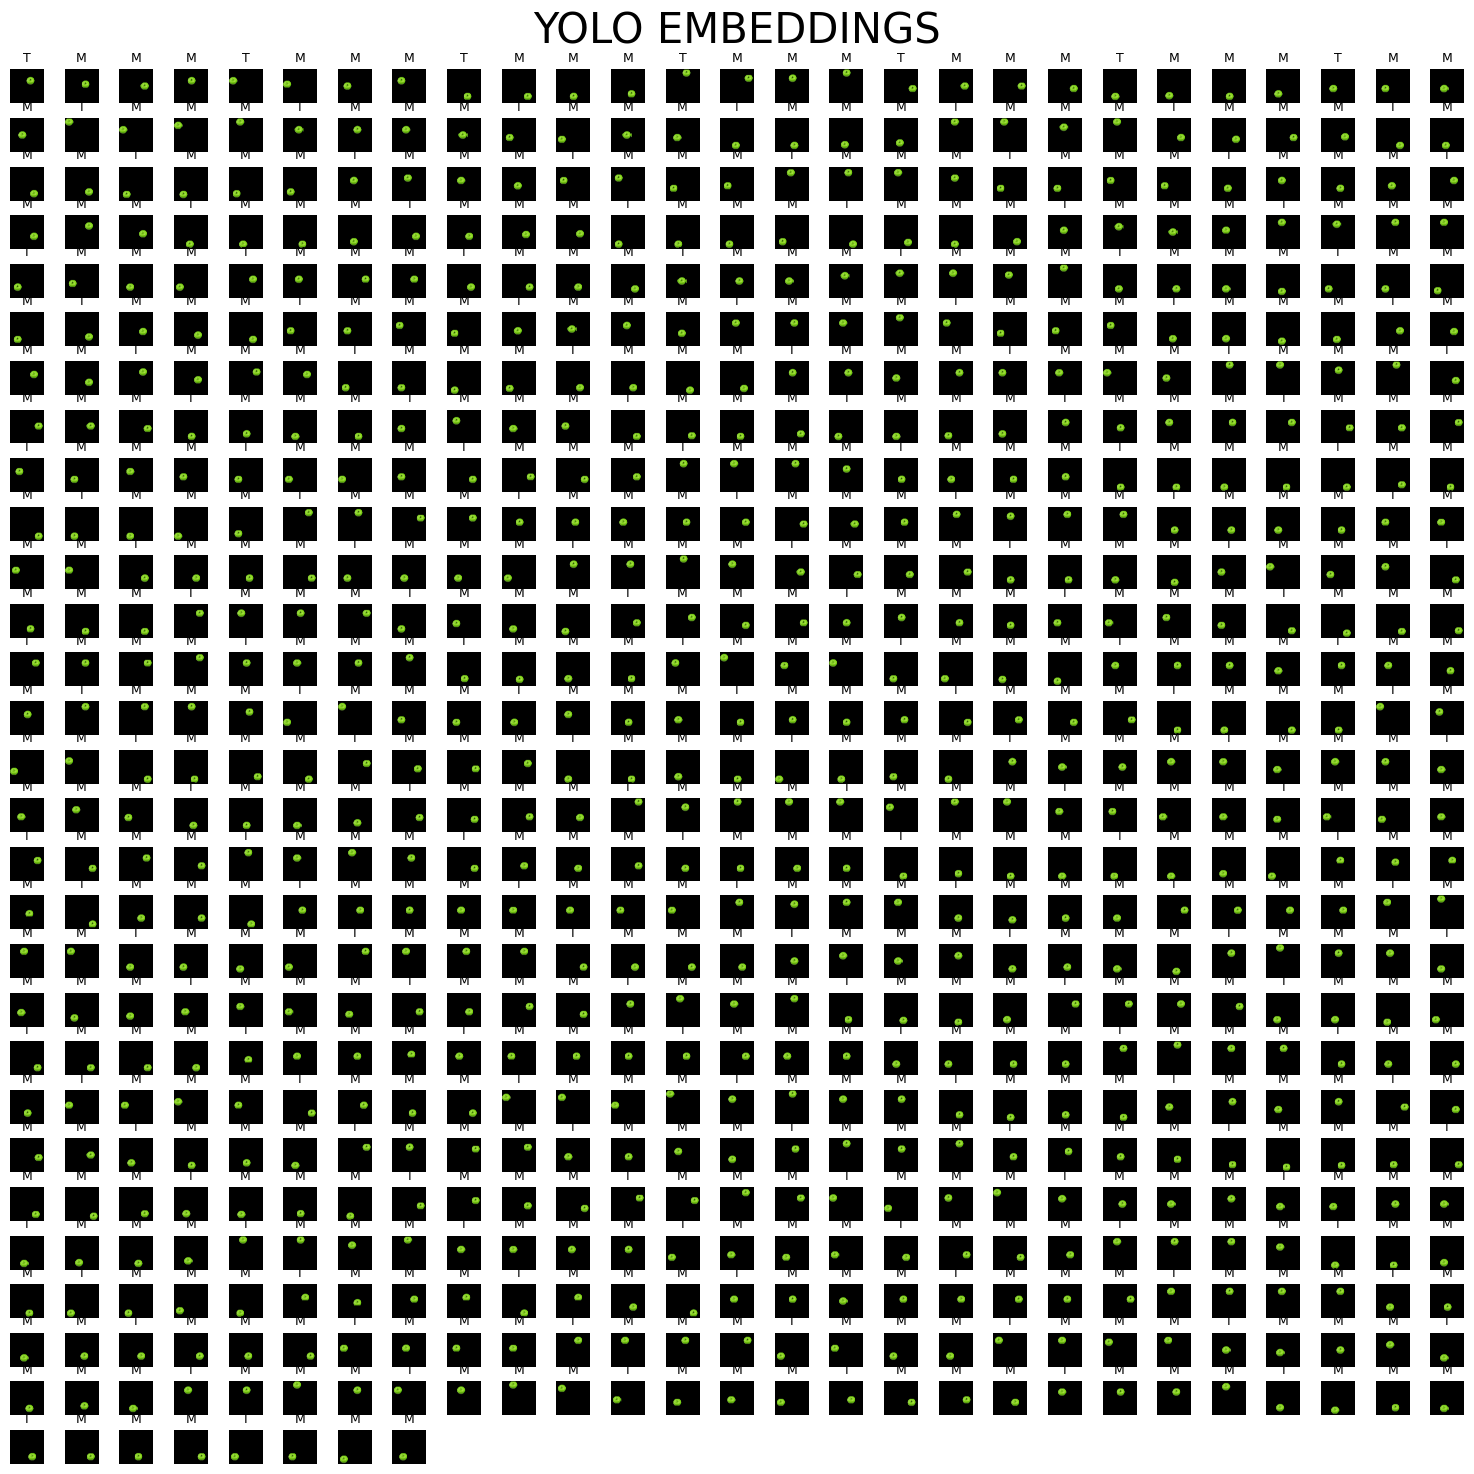

In [17]:
neighbours_inds = get_k_nearest(embedding_matrix, embedding_details["class_names"], 3)
plot_neighbours(embedding_details, neighbours_inds,
                masks_available = False,
                title = 'YOLO EMBEDDINGS',
                small_titles = True,
                show_full_img = True,
                subplot_title_hspace = 0.43,
                subplot_title_wspace = 0.1)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from utils.viz_utils import apply_pca
from utils.viz_utils import apply_tsne
from utils.viz_utils import plot_embeddings
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# def generate_data(n, d):
#     """ Generate a synthetic dataset of size nxd. """
#     return np.random.randn(n, d)

# def apply_pca(data, n_components=2):
#     """ Apply PCA to reduce dimensions to n_components. """
#     pca = PCA(n_components=n_components)
#     return pca.fit_transform(data), pca

# def apply_tsne(data, n_components=2, perplexity=30):
#     """ Apply t-SNE to reduce dimensions to n_components. """
#     tsne = TSNE(n_components=n_components, perplexity=perplexity)
#     return tsne.fit_transform(data), tsne

# def plot_embeddings(embeddings, title, colors, xscale = None, yscale = None):
#     """ Plot the 2D embeddings with matplotlib. """

#     fig, ax = plt.subplots()
#     x = np.linspace(0, 10, 100)
#     y = np.sin(x)
#     ax.scatter(embeddings[:, 0], embeddings[:, 1], c=colors, edgecolors='k')
#     ax.set_title(title)
#     ax.set_xlabel('Component 1')
#     ax.set_ylabel('Component 2')
#     ax.grid(True)
    
#     if xscale != None:
#         ax.set_xlim(xscale[0], xscale[1])
    
#     if yscale != None:
#         ax.set_ylim(yscale[0], yscale[1])
        
#     plt.close(fig)  # Prevent it from showing immediately
#     return fig


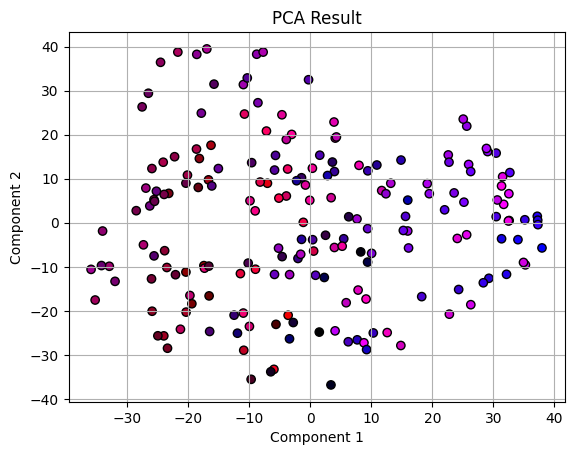

In [ ]:
fig.savefig('temp.jpg')

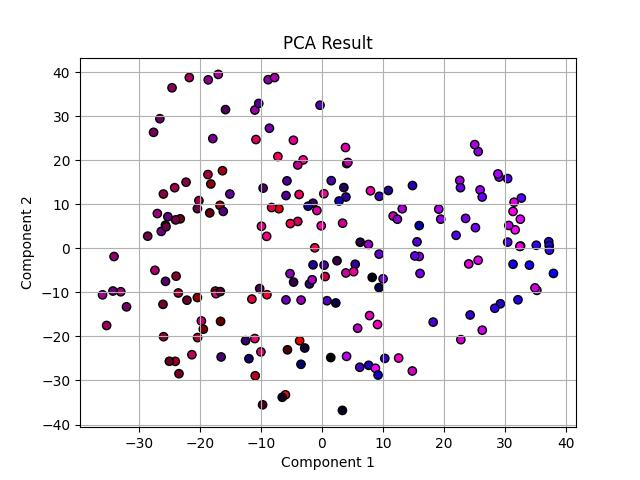

/usr/local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


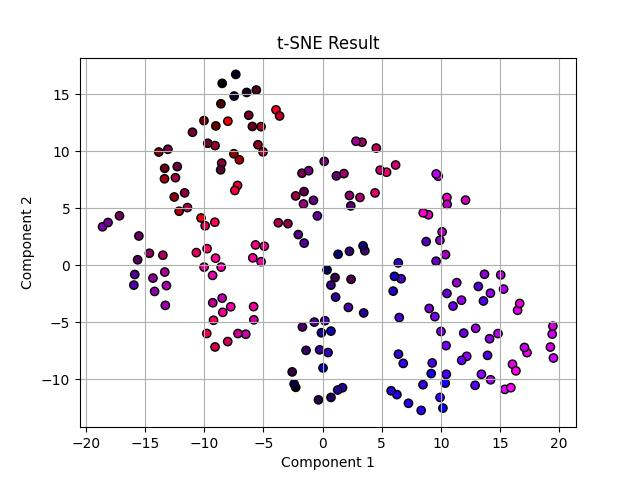

In [4]:
from IPython.display import Image as im
from IPython.display import display as dis
import numpy as np

from utils.viz_utils import create_frame

n = 100  # Number of data points
d = 5    # Number of dimensions


colors = np.array(embedding_details['bounding_boxes'])[:, 0, :][:, :2]
colors = (colors - np.min(colors, axis = 0)) / (np.max(colors, axis = 0) - np.min(colors, axis = 0))
colors = np.concatenate([colors, 
                          np.zeros([len(embedding_details['bounding_boxes']),1 ])], axis =1)[:, [0,2,1]]

pca_result, pca_model = apply_pca(embedding_matrix)
fig = plot_embeddings(pca_result, "PCA Result", colors.tolist())
fig.savefig('temp.jpg')
dis(im('temp.jpg'))

tsne_result, tsne_model = apply_tsne(embedding_matrix)

fig = plot_embeddings(tsne_result, "t-SNE Result", colors.tolist())
fig.savefig('temp.jpg')
dis(im('temp.jpg'))
